# McKinsey Challenge - HackUPC

Team **Spacers**:
* Hossein Yousefi
* Mateo Buitrago
* Animesh Bajpai
* Jonathan Harel

## Data Exploration

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

### Vehicles data

In [2]:
# Load the data
vehicles = pd.read_csv('data/vehicles.csv')

In [3]:
vehicles.shape

(455652, 22)

In [4]:
vehicles.head()

,accident_id,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type,Vehicle_IMD_Decile
0,430245,1,Car,No tow/articulation,Going ahead other,On main c'way - not in restricted lane,Approaching junction or waiting/parked at junc...,None,None,Did not leave carriageway,None,Front,No,Other,Male,18.0,1299.0,Petrol,16.0,4.0,3.0,4.0
1,430245,2,Car,No tow/articulation,Waiting to go - held up,On main c'way - not in restricted lane,Approaching junction or waiting/parked at junc...,None,None,Did not leave carriageway,None,Back,No,Journey as part of work,Female,24.0,1598.0,Heavy oil,1.0,9.0,1.0,9.0
2,387170,1,Car,No tow/articulation,Going ahead other,On main c'way - not in restricted lane,Not at or within 20 metres of junction,None,None,Did not leave carriageway,None,Offside,No,Journey as part of work,Male,54.0,-1.0,-1,-1.0,8.0,3.0,8.0
3,326114,1,Car,No tow/articulation,Turning right,On main c'way - not in restricted lane,Leaving main road,None,None,Did not leave carriageway,None,Nearside,No,Not known,Female,38.0,2935.0,Petrol,22.0,2.0,1.0,2.0
4,326114,2,Motorcycle over 125cc and up to 500cc,No tow/articulation,Going ahead other,On main c'way - not in restricted lane,Approaching junction or waiting/parked at junc...,Overturned,None,Did not leave carriageway,None,Front,No,Other,Male,21.0,399.0,Petrol,25.0,5.0,1.0,5.0


Feature processing:

In [5]:
# Handle towing
vehicles['towing_something'] = np.where(vehicles.Towing_and_Articulation.isin(['No tow/articulation', '-1']), 0, 1)

# Handle Skidding and Overturning
vehicles['skidded'] = np.where(vehicles.Skidding_and_Overturning.isin(['Skidded', 'Skidded and overturned']), 1, 0)
vehicles['overturned'] = np.where(vehicles.Skidding_and_Overturning.isin(['Overturned', 'Skidded and overturned']), 1, 0)
vehicles['jackknifed'] = np.where(vehicles.Skidding_and_Overturning.isin(['Jackknifed', 'Jackknifed and overturned']), 1, 0)

# Hit or no hit
vehicles['hit_anything'] = np.where(vehicles.Hit_Object_in_Carriageway.isin(['None', '-1']), 0, 1)
vehicles['hit_anything_carriageway'] = np.where(vehicles.Hit_Object_off_Carriageway.isin(['None', '-1']), 0, 1)

# Sex
vehicles['male'] = vehicles.Sex_of_Driver == 'Male'
vehicles['female'] = vehicles.Sex_of_Driver == 'Female'

# Age
vehicles['driver_age_young'] = np.where(vehicles.Age_of_Driver <= 25, 1, 0)
vehicles['driver_age_adult'] = np.where(vehicles.Age_of_Driver.between(26, 60), 1, 0)
vehicles['driver_age_old'] = np.where(vehicles.Age_of_Driver > 60, 1, 0)

# Engines
vehicles['engine_cap_1000'] = np.where(vehicles['Engine_Capacity_(CC)'] <= 1000, 1, 0)
vehicles['engine_cap_1500'] = np.where(vehicles['Engine_Capacity_(CC)'].between(1001, 1500), 1, 0)
vehicles['engine_cap_2000'] = np.where(vehicles['Engine_Capacity_(CC)'].between(1501, 2000), 1, 0)
vehicles['engine_cap_9999'] = np.where(vehicles['Engine_Capacity_(CC)'] > 2000, 1, 0)

# Age of vehicle
vehicles['vehicle_age_5'] = np.where(vehicles.Age_of_Vehicle <= 5, 1, 0)
vehicles['vehicle_age_10'] = np.where(vehicles.Age_of_Vehicle.between(6, 10), 1, 0)
vehicles['vehicle_age_15'] = np.where(vehicles.Age_of_Vehicle.between(11, 15), 1, 0)
vehicles['vehicle_age_99'] = np.where(vehicles.Age_of_Vehicle > 15, 1, 0)

In [6]:
one_hot_cols = [
    'Vehicle_Type',
    'Vehicle_Manoeuvre',
    'Vehicle_Location-Restricted_Lane',
    'Junction_Location',
    'Vehicle_Leaving_Carriageway',
    '1st_Point_of_Impact',
    'Journey_Purpose_of_Driver',
    'Driver_IMD_Decile',
    'Driver_Home_Area_Type',
    'Vehicle_IMD_Decile'
]
df = pd.concat([vehicles[['accident_id', 
                          'towing_something', 
                          'skidded', 'overturned', 'jackknifed', 
                          'hit_anything', 'hit_anything_carriageway',
                          'male', 'female',
                          'driver_age_young', 'driver_age_adult', 'driver_age_old',
                          'engine_cap_1000', 'engine_cap_1500', 'engine_cap_2000', 'engine_cap_9999',
                          'vehicle_age_5', 'vehicle_age_10', 'vehicle_age_15', 'vehicle_age_99',
                          ]]] + 
               [pd.get_dummies(vehicles[col], prefix=col) for col in one_hot_cols], 
               axis=1)

In [7]:
to_drop = [
    'Vehicle_Type_-1',
    'Vehicle_Manoeuvre_-1',
    'Vehicle_Location-Restricted_Lane_-1',
    'Junction_Location_-1',
    'Vehicle_Leaving_Carriageway_-1',
    '1st_Point_of_Impact_-1',
    'Journey_Purpose_of_Driver_-1',
    'Journey_Purpose_of_Driver_Not known',
    'Driver_IMD_Decile_-1.0',
    'Driver_Home_Area_Type_-1.0',
    'Vehicle_IMD_Decile_-1.0',
]
df.drop(to_drop, axis=1, inplace=True)

In [8]:
df.shape

(455652, 119)

In [9]:
grouped = df.groupby('accident_id').sum()

In [10]:
grouped.head()

,towing_something,skidded,overturned,jackknifed,hit_anything,hit_anything_carriageway,male,female,driver_age_young,driver_age_adult,driver_age_old,engine_cap_1000,engine_cap_1500,engine_cap_2000,engine_cap_9999,vehicle_age_5,vehicle_age_10,vehicle_age_15,vehicle_age_99,Vehicle_Type_Agricultural vehicle,Vehicle_Type_Bus or coach (17 or more pass seats),Vehicle_Type_Car,Vehicle_Type_Electric motorcycle,Vehicle_Type_Goods 7.5 tonnes mgw and over,Vehicle_Type_Goods over 3.5t. and under 7.5t,Vehicle_Type_Goods vehicle - unknown weight,Vehicle_Type_Minibus (8 - 16 passenger seats),Vehicle_Type_Mobility scooter,Vehicle_Type_Motorcycle - unknown cc,Vehicle_Type_Motorcycle 125cc and under,Vehicle_Type_Motorcycle 50cc and under,Vehicle_Type_Motorcycle over 125cc and up to 500cc,Vehicle_Type_Motorcycle over 500cc,Vehicle_Type_Other vehicle,Vehicle_Type_Pedal cycle,Vehicle_Type_Ridden horse,Vehicle_Type_Taxi/Private hire car,Vehicle_Type_Tram,Vehicle_Type_Van / Goods 3.5 tonnes mgw or under,Vehicle_Manoeuvre_Changing lane to left,Vehicle_Manoeuvre_Changing lane to right,Vehicle_Manoeuvre_Going ahead left-hand bend,Vehicle_Manoeuvre_Going ahead other,Vehicle_Manoeuvre_Going ahead right-hand bend,Vehicle_Manoeuvre_Moving off,Vehicle_Manoeuvre_Overtaking - nearside,Vehicle_Manoeuvre_Overtaking moving vehicle - offside,Vehicle_Manoeuvre_Overtaking static vehicle - offside,Vehicle_Manoeuvre_Parked,Vehicle_Manoeuvre_Reversing,Vehicle_Manoeuvre_Slowing or stopping,Vehicle_Manoeuvre_Turning left,Vehicle_Manoeuvre_Turning right,Vehicle_Manoeuvre_U-turn,Vehicle_Manoeuvre_Waiting to go - held up,Vehicle_Manoeuvre_Waiting to turn left,Vehicle_Manoeuvre_Waiting to turn right,Vehicle_Location-Restricted_Lane_Bus lane,Vehicle_Location-Restricted_Lane_Busway (including guided busway),Vehicle_Location-Restricted_Lane_Cycle lane (on main carriageway),Vehicle_Location-Restricted_Lane_Cycleway or shared use footway (not part of main carriageway),Vehicle_Location-Restricted_Lane_Entering lay-by or hard shoulder,Vehicle_Location-Restricted_Lane_Footway (pavement),Vehicle_Location-Restricted_Lane_Leaving lay-by or hard shoulder,Vehicle_Location-Restricted_Lane_On lay-by or hard shoulder,Vehicle_Location-Restricted_Lane_On main c'way - not in restricted lane,Vehicle_Location-Restricted_Lane_Tram/Light rail track,Junction_Location_Approaching junction or waiting/parked at junction approach,Junction_Location_Cleared junction or waiting/parked at junction exit,Junction_Location_Entering from slip road,Junction_Location_Entering main road,Junction_Location_Entering roundabout,Junction_Location_Leaving main road,Junction_Location_Leaving roundabout,Junction_Location_Mid Junction - on roundabout or on main road,Junction_Location_Not at or within 20 metres of junction,Vehicle_Leaving_Carriageway_Did not leave carriageway,Vehicle_Leaving_Carriageway_Nearside,Vehicle_Leaving_Carriageway_Nearside and rebounded,Vehicle_Leaving_Carriageway_Offside,Vehicle_Leaving_Carriageway_Offside - crossed central reservation,Vehicle_Leaving_Carriageway_Offside and rebounded,Vehicle_Leaving_Carriageway_Offside on to central reservation,Vehicle_Leaving_Carriageway_Offside on to centrl res + rebounded,Vehicle_Leaving_Carriageway_Straight ahead at junction,1st_Point_of_Impact_Back,1st_Point_of_Impact_Did not impact,1st_Point_of_Impact_Front,1st_Point_of_Impact_Nearside,1st_Point_of_Impact_Offside,Journey_Purpose_of_Driver_Commuting to/from work,Journey_Purpose_of_Driver_Journey as part of work,Journey_Purpose_of_Driver_Other,Journey_Purpose_of_Driver_Pupil riding to/from school,Journey_Purpose_of_Driver_Taking pupil to/from school,Driver_IMD_Decile_1.0,Driver_IMD_Decile_2.0,Driver_IMD_Decile_3.0,Driver_IMD_Decile_4.0,Driver_IMD_Decile_5.0,Driver_IMD_Decile_6.0,Driver_IMD_Decile_7.0,Driver_IMD_Decile_8.0,Driver_IMD_Decile_9.0,Driver_IMD_Decile_10.0,Driver_Home_Area_Type_1.0,Driver_Home_Area_Type_2.0,Driver_Home_Area_Type_3.0,Vehicle_IMD_Decile_1.0,Vehicle_IMD_Decile_2.0,Vehicle_IMD_Decile_3.

### Accidents

In [11]:
accidents = pd.read_csv('data/accidents.csv', parse_dates={'datetime': [7, 8]})

In [12]:
accidents.shape

(137599, 29)

In [13]:
accidents.head()

,datetime,accident_id,location_easting_osgr,location_northing_osgr,longitude,latitude,number_of_vehicles,number_of_casualties,1st_road_class,1st_road_number,road_type,speed_limit,junction_detail,junction_control,2nd_road_class,2nd_road_number,pedestrian_crossing-human_control,pedestrian_crossing-physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,lsoa_of_accident_location,police_force,local_authority_district,local_authority_highway,target
0,2016-01-11 02:30:00,359433,519310.0,188730.0,-0.279323,51.584754,2,1,A,4006,4,30.0,Not at junction or within 20 metres,-1,-1,0.0,None within 50 metres,No physical crossing facilities within 50 metres,Darkness - lights unlit,1,Dry,None,None,Urban,E01000543,Metropolitan Police,Brent,Brent,0
1,2016-01-11 00:37:00,446617,551920.0,174560.0,0.184928,51.449595,1,1,A,207,4,30.0,Other junction,Give way or uncontrolled,Unclassified,0.0,None within 50 metres,No physical crossing facilities within 50 metres,Darkness - lights lit,1,Dry,None,None,Urban,E01000375,Metropolitan Police,Bexley,Bexley,0
2,2016-01-11 01:25:00,342312,505930.0,183850.0,-0.473837,51.543563,1,1,A,4020,3,30.0,Roundabout,Give way or uncontrolled,A,4020.0,None within 50 metres,No physical crossing facilities within 50 metres,Darkness - lights lit,1,Dry,None,None,Urban,E01033725,Metropolitan Police,Hillingdon,Hillingdon,0
3,2016-01-11 09:15:00,495118,527770.0,168930.0,-0.164442,51.404958,1,1,A,217,4,30.0,T or staggered junction,Auto traffic signal,A,217.0,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,1,Dry,None,None,Urban,E01003379,Metropolitan Police,Merton,Merton,0
4,2016-01-11 07:53:00,595500,510740.0,177230.0,-0.406580,51.483139,2,1,A,312,1,40.0,Not at junction or within 20 metres,-1,-1,0.0,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,1,Dry,None,None,Urban,E01002583,Metropolitan Police,Hounslow,Hounslow,0


In [14]:
accidents.describe(include='all')

,datetime,accident_id,location_easting_osgr,location_northing_osgr,longitude,latitude,number_of_vehicles,number_of_casualties,1st_road_class,1st_road_number,road_type,speed_limit,junction_detail,junction_control,2nd_road_class,2nd_road_number,pedestrian_crossing-human_control,pedestrian_crossing-physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,lsoa_of_accident_location,police_force,local_authority_district,local_authority_highway,target
count,137599,137599.000000,1.375990e+05,1.375990e+05,137599.000000,137599.000000,137599.000000,137599.000000,137599,137599.000000,137599.000000,137599.000000,137599,137599,137599,137599.000000,137599,137599,137599,137599.000000,137599,137599,137599,137599,137599,137599,137599,137599,137599.000000
unique,92877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,10,6,7,NaN,4,7,6,NaN,6,9,7,2,28643,51,380,207,NaN
top,2016-11-18 08:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN,Not at junction or within 20 metres,Give way or uncontrolled,-1,NaN,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,NaN,Dry,None,None,Urban,-1,Metropolitan Police,Birmingham,Kent,NaN
freq,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61899,NaN,NaN,NaN,56788,64851,57375,NaN,136383,111218,99672,NaN,99951,134231,134876,89127,8408,24967,2816,4460,NaN
first,2016-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2016-12-31 23:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,449877.458593,4.583579e+05,3.053874e+05,-1.362293,52.366118,1.848066,1.327292,NaN,920.231237,3.478456,38.347735,NaN,NaN,NaN,321.889650,NaN,NaN,NaN,1.406813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.171513
std,NaN,86448.862940,1.562511e+05,2.690374e+05,1.575892,2.053587,0.710954,0.788879,NaN,1753.846056,1.122816,17.434401,NaN,NaN,NaN,1203.367579,NaN,NaN,NaN,1.145928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.376958
min,NaN,300000.000000,7.670200e+04,1.107500e+04,-11.640000,31.480000,1.000000,1.000000,NaN,0.000000,1.000000,20.000000,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,375105.500000,3.868110e+05,1.765800e+05,-2.221880,51.469141,1.000000,1.000000,NaN,0.000000,4.000000,30.000000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


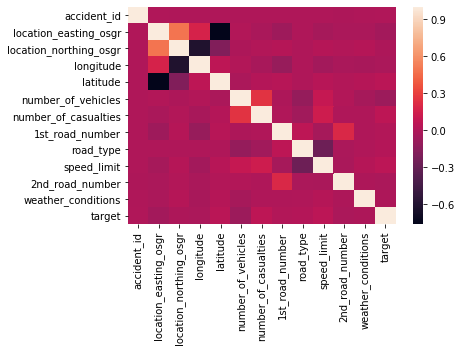

In [15]:
sns.heatmap(accidents.corr())

Feature processing:

In [16]:
# time related
accidents['month'] = accidents.datetime.dt.month
accidents['day'] = accidents.datetime.dt.day
accidents['hour'] = accidents.datetime.dt.hour
accidents['weekday'] = accidents.datetime.dt.dayofweek

# binning junction control
conditions = [
    (accidents.junction_control == 'Give way or uncontrolled'),
    (accidents.junction_control == '-1'),
    (accidents.junction_control == 'Auto traffic signal')
    ]
choices = [0, 1, 2]
accidents['junction_control_bins'] = np.select(conditions, choices, default=3)

# binning special conditions
conditions = [
    (accidents.special_conditions_at_site.isin(['-1', 'Auto signal part defective'])),
    (accidents.junction_control == 'None')
]
choices = [0, 1]
accidents['special_conditions_at_site_bins'] = np.select(conditions, choices, default=2)

# binning carriageway hazards
conditions = [
    (accidents.carriageway_hazards == '-1'),
    (accidents.carriageway_hazards == 'None')
]
choices = [0, 1]
accidents['carriageway_hazards_bins'] = np.select(conditions, choices, default=2)

# Features
accidents['casualties_ratio'] = accidents.number_of_casualties / accidents.number_of_vehicles

### Constructing the training dataframe

In [17]:
all_features = [
    'accident_id',
    'location_easting_osgr',
    'location_northing_osgr',
    'longitude',
    'latitude',
    'number_of_vehicles',
    'number_of_casualties',
    'casualties_ratio',
    '1st_road_class',
    'road_type',
    'speed_limit',
    'junction_detail',
    '2nd_road_class',
    'pedestrian_crossing-human_control',
    'pedestrian_crossing-physical_facilities',
    'light_conditions',
    'weather_conditions',
    'road_surface_conditions',
    'urban_or_rural_area',
    'lsoa_of_accident_location',
    'local_authority_district',
    'local_authority_highway',
    'month',
    'day',
    'hour',
    'weekday',
    'junction_control_bins',
    'special_conditions_at_site_bins',
    'carriageway_hazards_bins',
    'target'
]

In [18]:
categorical_features = [
    '1st_road_class',
    'road_type',
    '2nd_road_class',
    'junction_detail',
    'light_conditions',
    'weather_conditions',
    'road_surface_conditions',
    'urban_or_rural_area',
    'lsoa_of_accident_location',
    'local_authority_district',
    'local_authority_highway',
    'pedestrian_crossing-human_control',
    'pedestrian_crossing-physical_facilities',
    'month',
    'day',
    'hour',
    'weekday',
    'junction_control_bins',
    'special_conditions_at_site_bins',
    'carriageway_hazards_bins'
]

In [19]:
accidents_features = accidents[all_features]

In [20]:
accidents_features.head()

,accident_id,location_easting_osgr,location_northing_osgr,longitude,latitude,number_of_vehicles,number_of_casualties,casualties_ratio,1st_road_class,road_type,speed_limit,junction_detail,2nd_road_class,pedestrian_crossing-human_control,pedestrian_crossing-physical_facilities,light_conditions,weather_conditions,road_surface_conditions,urban_or_rural_area,lsoa_of_accident_location,local_authority_district,local_authority_highway,month,day,hour,weekday,junction_control_bins,special_conditions_at_site_bins,carriageway_hazards_bins,target
0,359433,519310.0,188730.0,-0.279323,51.584754,2,1,0.5,A,4,30.0,Not at junction or within 20 metres,-1,None within 50 metres,No physical crossing facilities within 50 metres,Darkness - lights unlit,1,Dry,Urban,E01000543,Brent,Brent,1,11,2,0,1,2,1,0
1,446617,551920.0,174560.0,0.184928,51.449595,1,1,1.0,A,4,30.0,Other junction,Unclassified,None within 50 metres,No physical crossing facilities within 50 metres,Darkness - lights lit,1,Dry,Urban,E01000375,Bexley,Bexley,1,11,0,0,0,2,1,0
2,342312,505930.0,183850.0,-0.473837,51.543563,1,1,1.0,A,3,30.0,Roundabout,A,None within 50 metres,No physical crossing facilities within 50 metres,Darkness - lights lit,1,Dry,Urban,E01033725,Hillingdon,Hillingdon,1,11,1,0,0,2,1,0
3,495118,527770.0,168930.0,-0.164442,51.404958,1,1,1.0,A,4,30.0,T or staggered junction,A,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,1,Dry,Urban,E01003379,Merton,Merton,1,11,9,0,2,2,1,0
4,595500,510740.0,177230.0,-0.406580,51.483139,2,1,0.5,A,1,40.0,Not at junction or within 20 metres,-1,None within 50 metres,No physical crossing facilities within 50 metres,Daylight,1,Dry,Urban,E01002583,Hounslow,Hounslow,1,11,7,0,1,2,1,0


In [21]:
data = accidents_features.merge(grouped, on=['accident_id'])

In [22]:
data.head()

,accident_id,location_easting_osgr,location_northing_osgr,longitude,latitude,number_of_vehicles,number_of_casualties,casualties_ratio,1st_road_class,road_type,speed_limit,junction_detail,2nd_road_class,pedestrian_crossing-human_control,pedestrian_crossing-physical_facilities,light_conditions,weather_conditions,road_surface_conditions,urban_or_rural_area,lsoa_of_accident_location,local_authority_district,local_authority_highway,month,day,hour,weekday,junction_control_bins,special_conditions_at_site_bins,carriageway_hazards_bins,target,towing_something,skidded,overturned,jackknifed,hit_anything,hit_anything_carriageway,male,female,driver_age_young,driver_age_adult,driver_age_old,engine_cap_1000,engine_cap_1500,engine_cap_2000,engine_cap_9999,vehicle_age_5,vehicle_age_10,vehicle_age_15,vehicle_age_99,Vehicle_Type_Agricultural vehicle,Vehicle_Type_Bus or coach (17 or more pass seats),Vehicle_Type_Car,Vehicle_Type_Electric motorcycle,Vehicle_Type_Goods 7.5 tonnes mgw and over,Vehicle_Type_Goods over 3.5t. and under 7.5t,Vehicle_Type_Goods vehicle - unknown weight,Vehicle_Type_Minibus (8 - 16 passenger seats),Vehicle_Type_Mobility scooter,Vehicle_Type_Motorcycle - unknown cc,Vehicle_Type_Motorcycle 125cc and under,Vehicle_Type_Motorcycle 50cc and under,Vehicle_Type_Motorcycle over 125cc and up to 500cc,Vehicle_Type_Motorcycle over 500cc,Vehicle_Type_Other vehicle,Vehicle_Type_Pedal cycle,Vehicle_Type_Ridden horse,Vehicle_Type_Taxi/Private hire car,Vehicle_Type_Tram,Vehicle_Type_Van / Goods 3.5 tonnes mgw or under,Vehicle_Manoeuvre_Changing lane to left,Vehicle_Manoeuvre_Changing lane to right,Vehicle_Manoeuvre_Going ahead left-hand bend,Vehicle_Manoeuvre_Going ahead other,Vehicle_Manoeuvre_Going ahead right-hand bend,Vehicle_Manoeuvre_Moving off,Vehicle_Manoeuvre_Overtaking - nearside,Vehicle_Manoeuvre_Overtaking moving vehicle - offside,Vehicle_Manoeuvre_Overtaking static vehicle - offside,Vehicle_Manoeuvre_Parked,Vehicle_Manoeuvre_Reversing,Vehicle_Manoeuvre_Slowing or stopping,Vehicle_Manoeuvre_Turning left,Vehicle_Manoeuvre_Turning right,Vehicle_Manoeuvre_U-turn,Vehicle_Manoeuvre_Waiting to go - held up,Vehicle_Manoeuvre_Waiting to turn left,Vehicle_Manoeuvre_Waiting to turn right,Vehicle_Location-Restricted_Lane_Bus lane,Vehicle_Location-Restricted_Lane_Busway (including guided busway),Vehicle_Location-Restricted_Lane_Cycle lane (on main carriageway),Vehicle_Location-Restricted_Lane_Cycleway or shared use footway (not part of main carriageway),Vehicle_Location-Restricted_Lane_Entering lay-by or hard shoulder,Vehicle_Location-Restricted_Lane_Footway (pavement),Vehicle_Location-Restricted_Lane_Leaving lay-by or hard shoulder,Vehicle_Location-Restricted_Lane_On lay-by or hard shoulder,Vehicle_Location-Restricted_Lane_On main c'way - not in restricted lane,Vehicle_Location-Restricted_Lane_Tram/Light rail track,Junction_Location_Approaching junction or waiting/parked at junction approach,Junction_Location_Cleared junction or waiting/parked at junction exit,Junction_Location_Entering from slip road,Junction_Location_Entering main road,Junction_Location_Entering roundabout,Junction_Location_Leaving main road,Junction_Location_Leaving roundabout,Junction_Location_Mid Junction - on roundabout or on main road,Junction_Location_Not at or within 20 metres of junction,Vehicle_Leaving_Carriageway_Did not leave carriageway,Vehicle_Leaving_Carriageway_Nearside,Vehicle_Leaving_Carriageway_Nearside and rebounded,Vehicle_Leaving_Carriageway_Offside,Vehicle_Leaving_Carriageway_Offside - crossed central reservation,Vehicle_Leaving_Carriageway_Offside and rebounded,Vehicle_Leaving_Carriageway_Offside on to central reservation,Vehicle_Leaving_Carriageway_Offside on to centrl res + rebounded,Vehicle_Leaving_Carriageway_Straight ahead at junction,1st_Point_of_Impact_Back,1st_Point_of_Impact_Did not impact,1st_Point_of_Impact_Front,1st_Point_of_Impact_Nearside,1st_Point_of_Impact_Offside,Journey_Purpose_of_Driver_Commuting to/from work,Journey_Purpose_o

## Preprocessing

Before we train any model, let's look at the target distribution:

In [23]:
data.target.value_counts()

0    113999
1     23600
Name: target, dtype: int64

![unbalanced](not_balanced.png)

Let's randomly downsample the dataset:

In [24]:
downsampled = pd.concat([data[data.target == 1], data[data.target == 0].sample(23600)], axis=0)

## Modeling and evaluation

We chose `CatBoost`, an ideal model for data with multiple categorical features. 

In [25]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(downsampled.drop(['accident_id', 'target'], axis=1), 
                                                    downsampled.target)
clf = CatBoostClassifier(cat_features=categorical_features, metric_period=25)
clf.fit(X_train, y_train)

Learning rate set to 0.045972
0:	learn: 0.6874297	total: 260ms	remaining: 4m 19s
25:	learn: 0.6270761	total: 4.7s	remaining: 2m 55s
50:	learn: 0.6112704	total: 8.9s	remaining: 2m 45s
75:	learn: 0.6037714	total: 13s	remaining: 2m 38s
100:	learn: 0.5986585	total: 17.1s	remaining: 2m 32s
125:	learn: 0.5950286	total: 20.4s	remaining: 2m 21s
150:	learn: 0.5922505	total: 23.6s	remaining: 2m 12s
175:	learn: 0.5905460	total: 26.8s	remaining: 2m 5s
200:	learn: 0.5884487	total: 30.3s	remaining: 2m
225:	learn: 0.5866382	total: 34s	remaining: 1m 56s
250:	learn: 0.5841882	total: 37.9s	remaining: 1m 53s
275:	learn: 0.5820466	total: 42.1s	remaining: 1m 50s
300:	learn: 0.5798475	total: 46.2s	remaining: 1m 47s
325:	learn: 0.5781694	total: 50.7s	remaining: 1m 44s
350:	learn: 0.5771973	total: 54.6s	remaining: 1m 40s
375:	learn: 0.5756518	total: 59.1s	remaining: 1m 38s
400:	learn: 0.5739024	total: 1m 3s	remaining: 1m 34s
425:	learn: 0.5727769	total: 1m 7s	remaining: 1m 31s
450:	learn: 0.5716487	total: 1m 

In [27]:
preds = clf.predict(X_test)

In [28]:
def eval_model(model, xtst, ytst):
    preds = model.predict(xtst)
    print(f'F1 Score: {f1_score(ytst, preds)}')
    print(f'acc Score: {accuracy_score(ytst, preds)}')
    print(f'precision Score: {precision_score(ytst, preds)}')
    print(f'recall Score: {recall_score(ytst, preds)}')

In [29]:
eval_model(clf, X_test, y_test)

F1 Score: 0.6913499877939621
acc Score: 0.6785593220338983
precision Score: 0.658911121451838
recall Score: 0.7271482369051695


Nice results on the out-of-the-box implementation. We can get even better results if we add two things:
1. Hyper-parameters optimization
2. Feature selection

### Feature selection

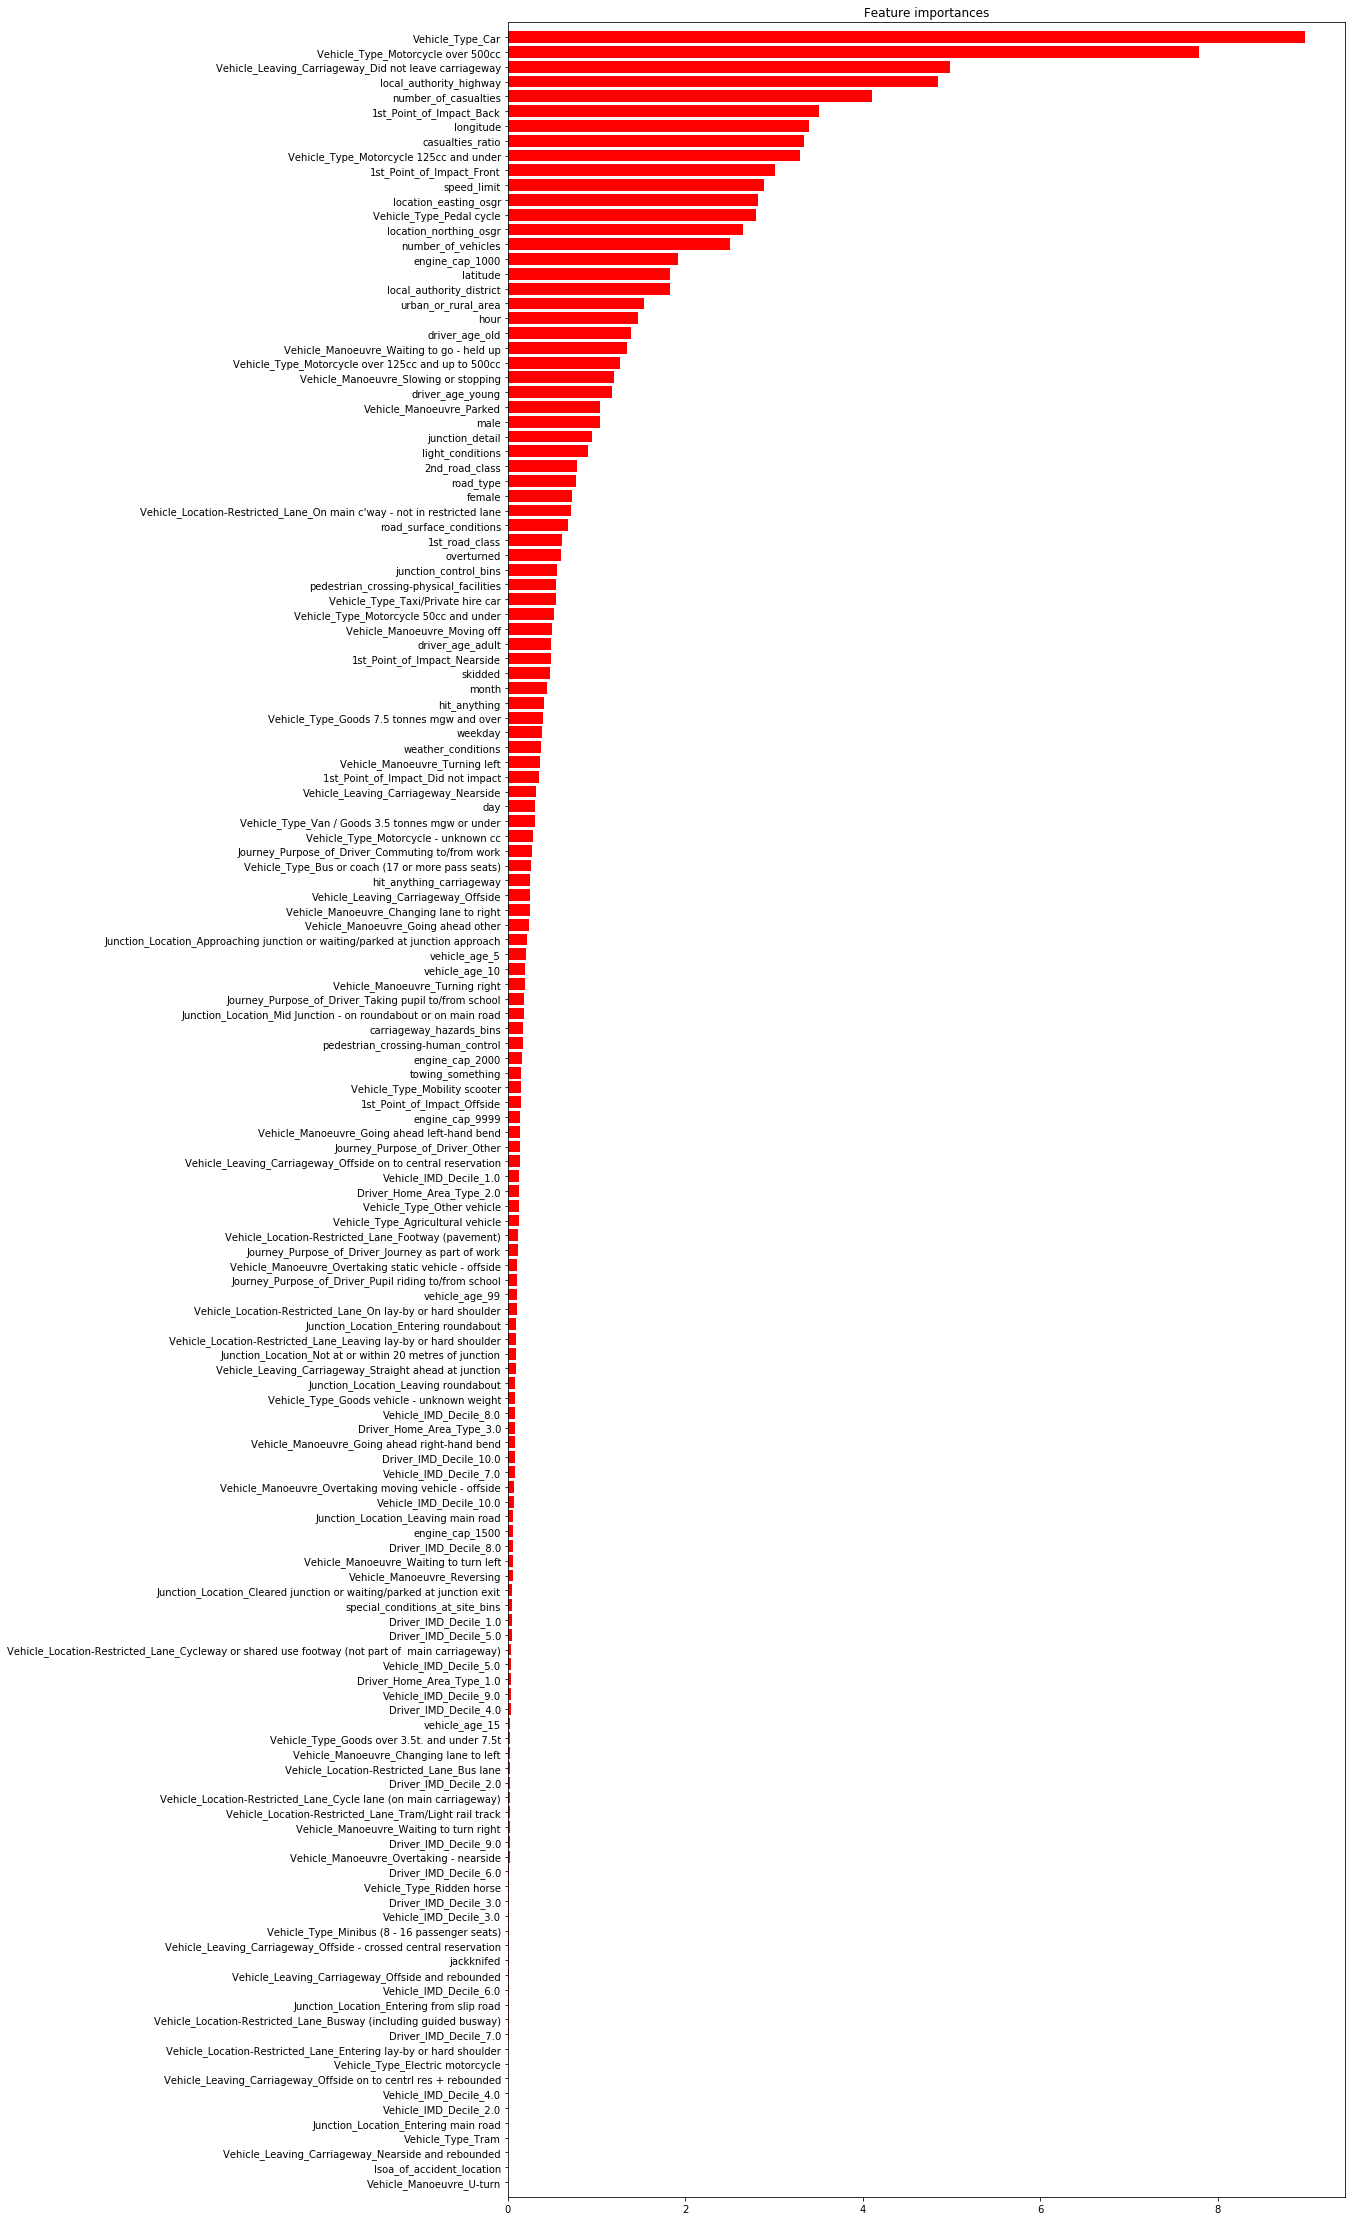

In [30]:
importances = clf.feature_importances_
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure(figsize=(15,40))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.yticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices])
plt.ylim([-1, X_train.shape[1]])
plt.show()

In [31]:
imp = zip([X_train.columns[i] for i in indices], importances[indices])
important_features = [feature for (feature, importance) in imp if importance > 0.1]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(downsampled[important_features], downsampled.target, random_state=42)
clf = CatBoostClassifier(cat_features=[f for f in categorical_features if f in important_features], metric_period=25)
clf.fit(X_train, y_train)

Learning rate set to 0.045972
0:	learn: 0.6872149	total: 155ms	remaining: 2m 34s
25:	learn: 0.6262493	total: 4.08s	remaining: 2m 32s
50:	learn: 0.6109470	total: 8.3s	remaining: 2m 34s
75:	learn: 0.6030802	total: 11.9s	remaining: 2m 24s
100:	learn: 0.5983924	total: 15.5s	remaining: 2m 18s
125:	learn: 0.5947813	total: 18.9s	remaining: 2m 11s
150:	learn: 0.5927184	total: 21.9s	remaining: 2m 3s
175:	learn: 0.5904568	total: 25.1s	remaining: 1m 57s
200:	learn: 0.5884693	total: 28.2s	remaining: 1m 52s
225:	learn: 0.5867895	total: 31.6s	remaining: 1m 48s
250:	learn: 0.5848426	total: 34.9s	remaining: 1m 44s
275:	learn: 0.5816892	total: 38.7s	remaining: 1m 41s
300:	learn: 0.5801630	total: 42.4s	remaining: 1m 38s
325:	learn: 0.5782466	total: 46.2s	remaining: 1m 35s
350:	learn: 0.5768454	total: 50s	remaining: 1m 32s
375:	learn: 0.5758621	total: 53.9s	remaining: 1m 29s
400:	learn: 0.5746560	total: 57.7s	remaining: 1m 26s
425:	learn: 0.5734906	total: 1m 1s	remaining: 1m 22s
450:	learn: 0.5726075	tot

In [33]:
eval_model(clf, X_test, y_test)

F1 Score: 0.6965517241379311
acc Score: 0.679322033898305
precision Score: 0.6627498855486037
recall Score: 0.7339868176440764


In [34]:
clf.save_model('model.cbm', format="cbm")

### Hyper parameters optimization

In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
# Fast iterations to find the best set
params = {'depth':[2,6,4,8,10],
          'iterations':[100],
          'learning_rate':[0.03,0.001,0.01,0.1], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[5,10,20,50,100]}

model = CatBoostClassifier(cat_features=[f for f in categorical_features if f in important_features])
gscv = GridSearchCV(estimator=model, param_grid=params, cv=2, n_jobs=-1)

In [37]:
gscv.fit(X_train, y_train)

0:	learn: 0.6799951	total: 67.5ms	remaining: 6.68s
1:	learn: 0.6691570	total: 157ms	remaining: 7.68s
2:	learn: 0.6605540	total: 219ms	remaining: 7.1s
3:	learn: 0.6530523	total: 286ms	remaining: 6.86s
4:	learn: 0.6459814	total: 356ms	remaining: 6.76s
5:	learn: 0.6398344	total: 440ms	remaining: 6.9s
6:	learn: 0.6347601	total: 514ms	remaining: 6.82s
7:	learn: 0.6305578	total: 578ms	remaining: 6.64s
8:	learn: 0.6262372	total: 642ms	remaining: 6.49s
9:	learn: 0.6226015	total: 715ms	remaining: 6.44s
10:	learn: 0.6195048	total: 776ms	remaining: 6.28s
11:	learn: 0.6168606	total: 838ms	remaining: 6.14s
12:	learn: 0.6142289	total: 900ms	remaining: 6.02s
13:	learn: 0.6118168	total: 963ms	remaining: 5.91s
14:	learn: 0.6098529	total: 1.02s	remaining: 5.81s
15:	learn: 0.6082235	total: 1.09s	remaining: 5.73s
16:	learn: 0.6063514	total: 1.15s	remaining: 5.63s
17:	learn: 0.6048471	total: 1.22s	remaining: 5.55s
18:	learn: 0.6042443	total: 1.26s	remaining: 5.36s
19:	learn: 0.6027681	total: 1.32s	remainin

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x00000241837AD518>,
             iid='warn', n_jobs=-1,
             param_grid={'border_count': [5, 10, 20, 50, 100],
                         'depth': [2, 6, 4, 8, 10], 'iterations': [100],
                         'l2_leaf_reg': [3, 1, 5, 10, 100],
                         'learning_rate': [0.03, 0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [38]:
# Increase the number of iterations for better training
best_params = gscv.best_params_
best_params['iterations'] = 1000

In [39]:
# Evaluation
new_model = CatBoostClassifier(cat_features=[f for f in categorical_features if f in important_features], **best_params)
new_model.fit(X_train, y_train)

0:	learn: 0.6805494	total: 204ms	remaining: 3m 24s
1:	learn: 0.6703650	total: 410ms	remaining: 3m 24s
2:	learn: 0.6617016	total: 619ms	remaining: 3m 25s
3:	learn: 0.6552004	total: 841ms	remaining: 3m 29s
4:	learn: 0.6499021	total: 959ms	remaining: 3m 10s
5:	learn: 0.6436196	total: 1.17s	remaining: 3m 13s
6:	learn: 0.6386215	total: 1.39s	remaining: 3m 17s
7:	learn: 0.6341815	total: 1.59s	remaining: 3m 17s
8:	learn: 0.6308845	total: 1.81s	remaining: 3m 19s
9:	learn: 0.6281140	total: 2.02s	remaining: 3m 20s
10:	learn: 0.6251457	total: 2.24s	remaining: 3m 21s
11:	learn: 0.6232897	total: 2.45s	remaining: 3m 21s
12:	learn: 0.6209621	total: 2.64s	remaining: 3m 20s
13:	learn: 0.6195053	total: 2.88s	remaining: 3m 22s
14:	learn: 0.6173098	total: 3.08s	remaining: 3m 22s
15:	learn: 0.6157752	total: 3.29s	remaining: 3m 22s
16:	learn: 0.6140517	total: 3.45s	remaining: 3m 19s
17:	learn: 0.6129012	total: 3.65s	remaining: 3m 19s
18:	learn: 0.6115056	total: 3.88s	remaining: 3m 20s
19:	learn: 0.6104692	t

158:	learn: 0.5711896	total: 29.9s	remaining: 2m 37s
159:	learn: 0.5710683	total: 30.1s	remaining: 2m 38s
160:	learn: 0.5709790	total: 30.4s	remaining: 2m 38s
161:	learn: 0.5709363	total: 30.7s	remaining: 2m 38s
162:	learn: 0.5708324	total: 30.9s	remaining: 2m 38s
163:	learn: 0.5707617	total: 31.1s	remaining: 2m 38s
164:	learn: 0.5707203	total: 31.4s	remaining: 2m 39s
165:	learn: 0.5706902	total: 31.7s	remaining: 2m 39s
166:	learn: 0.5704646	total: 31.9s	remaining: 2m 39s
167:	learn: 0.5703288	total: 32.1s	remaining: 2m 39s
168:	learn: 0.5702770	total: 32.4s	remaining: 2m 39s
169:	learn: 0.5697782	total: 32.6s	remaining: 2m 39s
170:	learn: 0.5697078	total: 32.9s	remaining: 2m 39s
171:	learn: 0.5695071	total: 33.1s	remaining: 2m 39s
172:	learn: 0.5693899	total: 33.4s	remaining: 2m 39s
173:	learn: 0.5690120	total: 33.6s	remaining: 2m 39s
174:	learn: 0.5689360	total: 33.9s	remaining: 2m 39s
175:	learn: 0.5688472	total: 34.1s	remaining: 2m 39s
176:	learn: 0.5688193	total: 34.4s	remaining: 

314:	learn: 0.5546262	total: 1m 9s	remaining: 2m 30s
315:	learn: 0.5546077	total: 1m 9s	remaining: 2m 29s
316:	learn: 0.5546048	total: 1m 9s	remaining: 2m 29s
317:	learn: 0.5545211	total: 1m 9s	remaining: 2m 29s
318:	learn: 0.5545135	total: 1m 9s	remaining: 2m 29s
319:	learn: 0.5545042	total: 1m 10s	remaining: 2m 29s
320:	learn: 0.5544753	total: 1m 10s	remaining: 2m 29s
321:	learn: 0.5543236	total: 1m 10s	remaining: 2m 28s
322:	learn: 0.5542853	total: 1m 10s	remaining: 2m 28s
323:	learn: 0.5542608	total: 1m 11s	remaining: 2m 28s
324:	learn: 0.5541949	total: 1m 11s	remaining: 2m 28s
325:	learn: 0.5541760	total: 1m 11s	remaining: 2m 28s
326:	learn: 0.5541178	total: 1m 11s	remaining: 2m 28s
327:	learn: 0.5535961	total: 1m 12s	remaining: 2m 27s
328:	learn: 0.5535002	total: 1m 12s	remaining: 2m 27s
329:	learn: 0.5534265	total: 1m 12s	remaining: 2m 27s
330:	learn: 0.5532868	total: 1m 12s	remaining: 2m 27s
331:	learn: 0.5532297	total: 1m 13s	remaining: 2m 27s
332:	learn: 0.5530783	total: 1m 1

467:	learn: 0.5441913	total: 1m 47s	remaining: 2m 2s
468:	learn: 0.5441789	total: 1m 47s	remaining: 2m 1s
469:	learn: 0.5440579	total: 1m 48s	remaining: 2m 1s
470:	learn: 0.5440177	total: 1m 48s	remaining: 2m 1s
471:	learn: 0.5440116	total: 1m 48s	remaining: 2m 1s
472:	learn: 0.5439998	total: 1m 48s	remaining: 2m 1s
473:	learn: 0.5439969	total: 1m 49s	remaining: 2m 1s
474:	learn: 0.5439297	total: 1m 49s	remaining: 2m
475:	learn: 0.5439284	total: 1m 49s	remaining: 2m
476:	learn: 0.5437968	total: 1m 49s	remaining: 2m
477:	learn: 0.5435013	total: 1m 50s	remaining: 2m
478:	learn: 0.5434682	total: 1m 50s	remaining: 1m 59s
479:	learn: 0.5433644	total: 1m 50s	remaining: 1m 59s
480:	learn: 0.5432906	total: 1m 50s	remaining: 1m 59s
481:	learn: 0.5432821	total: 1m 50s	remaining: 1m 59s
482:	learn: 0.5431483	total: 1m 51s	remaining: 1m 59s
483:	learn: 0.5431465	total: 1m 51s	remaining: 1m 58s
484:	learn: 0.5431091	total: 1m 51s	remaining: 1m 58s
485:	learn: 0.5431017	total: 1m 52s	remaining: 1m 5

621:	learn: 0.5353993	total: 2m 27s	remaining: 1m 29s
622:	learn: 0.5351670	total: 2m 28s	remaining: 1m 29s
623:	learn: 0.5350672	total: 2m 28s	remaining: 1m 29s
624:	learn: 0.5349550	total: 2m 28s	remaining: 1m 29s
625:	learn: 0.5349453	total: 2m 28s	remaining: 1m 28s
626:	learn: 0.5347926	total: 2m 29s	remaining: 1m 28s
627:	learn: 0.5347894	total: 2m 29s	remaining: 1m 28s
628:	learn: 0.5347767	total: 2m 29s	remaining: 1m 28s
629:	learn: 0.5347114	total: 2m 29s	remaining: 1m 27s
630:	learn: 0.5346717	total: 2m 30s	remaining: 1m 27s
631:	learn: 0.5346682	total: 2m 30s	remaining: 1m 27s
632:	learn: 0.5346281	total: 2m 30s	remaining: 1m 27s
633:	learn: 0.5346265	total: 2m 30s	remaining: 1m 27s
634:	learn: 0.5345873	total: 2m 31s	remaining: 1m 26s
635:	learn: 0.5345325	total: 2m 31s	remaining: 1m 26s
636:	learn: 0.5345172	total: 2m 31s	remaining: 1m 26s
637:	learn: 0.5345143	total: 2m 31s	remaining: 1m 26s
638:	learn: 0.5343749	total: 2m 32s	remaining: 1m 25s
639:	learn: 0.5343714	total:

776:	learn: 0.5266709	total: 3m 8s	remaining: 54.1s
777:	learn: 0.5266012	total: 3m 8s	remaining: 53.9s
778:	learn: 0.5265993	total: 3m 9s	remaining: 53.7s
779:	learn: 0.5265827	total: 3m 9s	remaining: 53.4s
780:	learn: 0.5265713	total: 3m 9s	remaining: 53.2s
781:	learn: 0.5265487	total: 3m 9s	remaining: 52.9s
782:	learn: 0.5265478	total: 3m 10s	remaining: 52.7s
783:	learn: 0.5265466	total: 3m 10s	remaining: 52.5s
784:	learn: 0.5265446	total: 3m 10s	remaining: 52.2s
785:	learn: 0.5265271	total: 3m 10s	remaining: 52s
786:	learn: 0.5265044	total: 3m 11s	remaining: 51.7s
787:	learn: 0.5264814	total: 3m 11s	remaining: 51.5s
788:	learn: 0.5264767	total: 3m 11s	remaining: 51.3s
789:	learn: 0.5264718	total: 3m 11s	remaining: 51s
790:	learn: 0.5264156	total: 3m 12s	remaining: 50.8s
791:	learn: 0.5263493	total: 3m 12s	remaining: 50.6s
792:	learn: 0.5263486	total: 3m 12s	remaining: 50.3s
793:	learn: 0.5263355	total: 3m 13s	remaining: 50.1s
794:	learn: 0.5263339	total: 3m 13s	remaining: 49.8s
795

932:	learn: 0.5212986	total: 3m 49s	remaining: 16.5s
933:	learn: 0.5212920	total: 3m 49s	remaining: 16.2s
934:	learn: 0.5212743	total: 3m 50s	remaining: 16s
935:	learn: 0.5212737	total: 3m 50s	remaining: 15.7s
936:	learn: 0.5212398	total: 3m 50s	remaining: 15.5s
937:	learn: 0.5212087	total: 3m 50s	remaining: 15.3s
938:	learn: 0.5212076	total: 3m 51s	remaining: 15s
939:	learn: 0.5211114	total: 3m 51s	remaining: 14.8s
940:	learn: 0.5211086	total: 3m 51s	remaining: 14.5s
941:	learn: 0.5211003	total: 3m 51s	remaining: 14.3s
942:	learn: 0.5210336	total: 3m 52s	remaining: 14s
943:	learn: 0.5210148	total: 3m 52s	remaining: 13.8s
944:	learn: 0.5209587	total: 3m 52s	remaining: 13.5s
945:	learn: 0.5208953	total: 3m 52s	remaining: 13.3s
946:	learn: 0.5208937	total: 3m 53s	remaining: 13.1s
947:	learn: 0.5208916	total: 3m 53s	remaining: 12.8s
948:	learn: 0.5208912	total: 3m 53s	remaining: 12.6s
949:	learn: 0.5208906	total: 3m 53s	remaining: 12.3s
950:	learn: 0.5208456	total: 3m 54s	remaining: 12.1s

In [40]:
eval_model(new_model, X_test, y_test)

F1 Score: 0.6982229402261713
acc Score: 0.6833898305084746
precision Score: 0.668729692093455
recall Score: 0.7304377218184891


Nice.

In [41]:
new_model.save_model('model.cbm', format="cbm")

## Test set

Now let's produce predictions for the test set

In [42]:
# Load the model
classifier = CatBoostClassifier()
classifier.load_model("model.cbm")

In [43]:
test = pd.read_csv('data/test.csv', parse_dates={'datetime': [7, 8]})

In [44]:
# time related
test['month'] = test.datetime.dt.month
test['day'] = test.datetime.dt.day
test['hour'] = test.datetime.dt.hour
test['weekday'] = test.datetime.dt.dayofweek

# binning junction control
conditions = [
    (test.junction_control == 'Give way or uncontrolled'),
    (test.junction_control == '-1'),
    (test.junction_control == 'Auto traffic signal')
    ]
choices = [0, 1, 2]
test['junction_control_bins'] = np.select(conditions, choices, default=3)

# binning special conditions
conditions = [
    (test.special_conditions_at_site.isin(['-1', 'Auto signal part defective'])),
    (test.junction_control == 'None')
]
choices = [0, 1]
test['special_conditions_at_site_bins'] = np.select(conditions, choices, default=2)

# binning carriageway hazards
conditions = [
    (test.carriageway_hazards == '-1'),
    (test.carriageway_hazards == 'None')
]
choices = [0, 1]
test['carriageway_hazards_bins'] = np.select(conditions, choices, default=2)

# Features
test['casualties_ratio'] = test.number_of_casualties / test.number_of_vehicles

In [45]:
joined = test.merge(grouped, on='accident_id', how='left').fillna(0)

In [46]:
joined.head()

,datetime,accident_id,location_easting_osgr,location_northing_osgr,longitude,latitude,number_of_vehicles,number_of_casualties,1st_road_class,1st_road_number,road_type,speed_limit,junction_detail,junction_control,2nd_road_class,2nd_road_number,pedestrian_crossing-human_control,pedestrian_crossing-physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,lsoa_of_accident_location,police_force,local_authority_district,local_authority_highway,month,day,hour,weekday,junction_control_bins,special_conditions_at_site_bins,carriageway_hazards_bins,casualties_ratio,towing_something,skidded,overturned,jackknifed,hit_anything,hit_anything_carriageway,male,female,driver_age_young,driver_age_adult,driver_age_old,engine_cap_1000,engine_cap_1500,engine_cap_2000,engine_cap_9999,vehicle_age_5,vehicle_age_10,vehicle_age_15,vehicle_age_99,Vehicle_Type_Agricultural vehicle,Vehicle_Type_Bus or coach (17 or more pass seats),Vehicle_Type_Car,Vehicle_Type_Electric motorcycle,Vehicle_Type_Goods 7.5 tonnes mgw and over,Vehicle_Type_Goods over 3.5t. and under 7.5t,Vehicle_Type_Goods vehicle - unknown weight,Vehicle_Type_Minibus (8 - 16 passenger seats),Vehicle_Type_Mobility scooter,Vehicle_Type_Motorcycle - unknown cc,Vehicle_Type_Motorcycle 125cc and under,Vehicle_Type_Motorcycle 50cc and under,Vehicle_Type_Motorcycle over 125cc and up to 500cc,Vehicle_Type_Motorcycle over 500cc,Vehicle_Type_Other vehicle,Vehicle_Type_Pedal cycle,Vehicle_Type_Ridden horse,Vehicle_Type_Taxi/Private hire car,Vehicle_Type_Tram,Vehicle_Type_Van / Goods 3.5 tonnes mgw or under,Vehicle_Manoeuvre_Changing lane to left,Vehicle_Manoeuvre_Changing lane to right,Vehicle_Manoeuvre_Going ahead left-hand bend,Vehicle_Manoeuvre_Going ahead other,Vehicle_Manoeuvre_Going ahead right-hand bend,Vehicle_Manoeuvre_Moving off,Vehicle_Manoeuvre_Overtaking - nearside,Vehicle_Manoeuvre_Overtaking moving vehicle - offside,Vehicle_Manoeuvre_Overtaking static vehicle - offside,Vehicle_Manoeuvre_Parked,Vehicle_Manoeuvre_Reversing,Vehicle_Manoeuvre_Slowing or stopping,Vehicle_Manoeuvre_Turning left,Vehicle_Manoeuvre_Turning right,Vehicle_Manoeuvre_U-turn,Vehicle_Manoeuvre_Waiting to go - held up,Vehicle_Manoeuvre_Waiting to turn left,Vehicle_Manoeuvre_Waiting to turn right,Vehicle_Location-Restricted_Lane_Bus lane,Vehicle_Location-Restricted_Lane_Busway (including guided busway),Vehicle_Location-Restricted_Lane_Cycle lane (on main carriageway),Vehicle_Location-Restricted_Lane_Cycleway or shared use footway (not part of main carriageway),Vehicle_Location-Restricted_Lane_Entering lay-by or hard shoulder,Vehicle_Location-Restricted_Lane_Footway (pavement),Vehicle_Location-Restricted_Lane_Leaving lay-by or hard shoulder,Vehicle_Location-Restricted_Lane_On lay-by or hard shoulder,Vehicle_Location-Restricted_Lane_On main c'way - not in restricted lane,Vehicle_Location-Restricted_Lane_Tram/Light rail track,Junction_Location_Approaching junction or waiting/parked at junction approach,Junction_Location_Cleared junction or waiting/parked at junction exit,Junction_Location_Entering from slip road,Junction_Location_Entering main road,Junction_Location_Entering roundabout,Junction_Location_Leaving main road,Junction_Location_Leaving roundabout,Junction_Location_Mid Junction - on roundabout or on main road,Junction_Location_Not at or within 20 metres of junction,Vehicle_Leaving_Carriageway_Did not leave carriageway,Vehicle_Leaving_Carriageway_Nearside,Vehicle_Leaving_Carriageway_Nearside and rebounded,Vehicle_Leaving_Carriageway_Offside,Vehicle_Leaving_Carriageway_Offside - crossed central reservation,Vehicle_Leaving_Carriageway_Offside and rebounded,Vehicle_Leaving_Carriageway_Offside on to central reservation,Vehicle_Leaving_Carriageway_Offside on to centrl res + rebounded,Vehicle_Leaving_Carriageway_Straight ahead at junction,1st_Point_of_Impact_Back,1st_Point_of_Impact_Did not impact,1st_Point_of_Impact_Front,1st_Point_of

In [47]:
joined['predictions'] = classifier.predict(joined[important_features])

In [48]:
joined[['accident_id', 'predictions']].to_csv('submission.csv', index=False)